# Michelle's Data (HeCS_pared_small.npy)

In [11]:
import numpy as np
dat = np.load('./data/HeCS_pared_small.npy')

# for n in range(len(dat)):
#     print('')
#     Ngal = dat['Ngal'][n]
#     print('cluster index:', n)
#     print('velocity standard deviation:', np.std(dat['vlos'][n][0:Ngal])) 
#     print ('cluster M500 from SZ:', dat['MSZ'][n])
#     print ('cluster M200c:', dat['Mtot'][n])
#     print ('  ')

In [12]:
import pandas as pd

datasum = pd.DataFrame(columns = ['velsigma','M500_SZ','M200c'], index = range(len(dat)))

for n in range(len(dat)):
    Ngal = dat['Ngal'][n]
    
    velsigma = np.std(dat['vlos'][n][0:Ngal])
    m500 = dat['MSZ'][n]
    m200c = dat['Mtot'][n]
    
    datasum.loc[n] = pd.Series({'velsigma':velsigma ,
                                'M500_SZ' : m500 ,
                                'M200c' : m200c })

In [13]:

## PURE POWER LAW
alpha = 0.382
sig15 = 1244

## CONTAMINATED POWER LAW
# alpha = 0.359
# sig15 = 753

M_pow = (datasum['velsigma']/sig15)**(1/alpha) * 1.e15
M_pow.name = 'M_powlaw'

ep_m200c = (M_pow - datasum['M200c'])/datasum['M200c']
ep_m200c.name = 'ep_M200c'

datacalc = pd.concat([M_pow,ep_m200c], axis=1)

In [14]:
datares = datasum.join(datacalc)

datares.head(15)

,velsigma,M500_SZ,M200c,M_powlaw,ep_M200c
0,843.07,2.324e+14,2.77e+14,3.61164e+14,0.30384
1,747.848,2.681e+14,2.92e+14,2.63905e+14,-0.0962168
2,426.237,1.141e+14,1.19e+14,6.0573e+13,-0.490983
3,753.334,3.43e+14,2.5e+14,2.69003e+14,0.0760117
4,690.516,2.338e+14,1.77e+14,2.14175e+14,0.210027
5,485.47,1.309e+14,2.02e+14,8.51558e+13,-0.578437
6,670.823,1.26e+14,1.34e+14,1.98552e+14,0.48173
7,706.867,2.8e+14,2.26e+14,2.27706e+14,0.00754944
8,750.748,3.437e+14,2.04e+14,2.66592e+14,0.306824
9,781.662,3.409e+14,4.04e+14,2.96295e+14,-0.266597


In [15]:
import matplotlib as mpl
% matplotlib inline
mpl.rcParams['figure.figsize'] = [10.,10.]

plt = mpl.pyplot

In [44]:
def plothist(X,Y, n=10):
    increment = (X.max() - X.min())/n
    
    i = X.min()
    
    y = []
    err = []
    while i < X.max():
        y.append(Y[(X>=i) & (X<(i+increment))].mean())
        err.append(Y[(X>=i) & (X<(i+increment))].std())
        i += increment
        
    plt.errorbar(np.array(range(n))*increment + X.min() + increment/2.,
                 y,
                 err,
                )

RuntimeError: xdata and ydata must be the same length

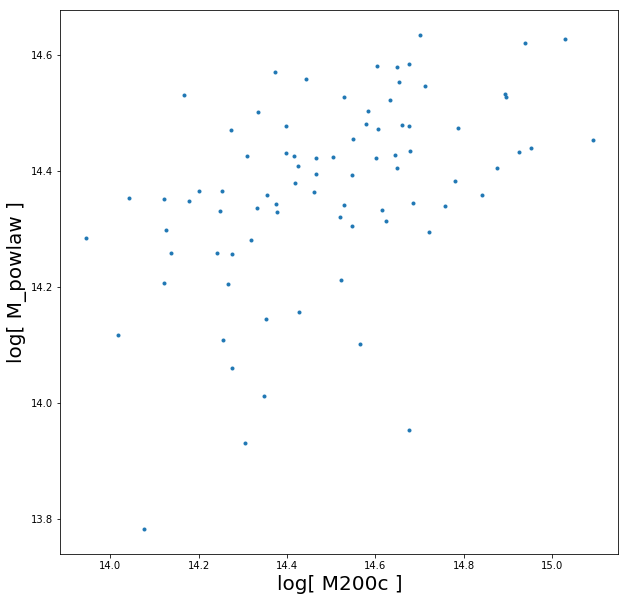

In [43]:
X = np.log10(datares['M200c'].astype('float64'))
Y = np.log10(datares['M_powlaw'].astype('float64'))
plt.plot(X,Y,'.')
plt.xlabel('log[ M200c ]', fontsize=20)
plt.ylabel('log[ M_powlaw ]', fontsize=20)

plothist(X,Y,10)

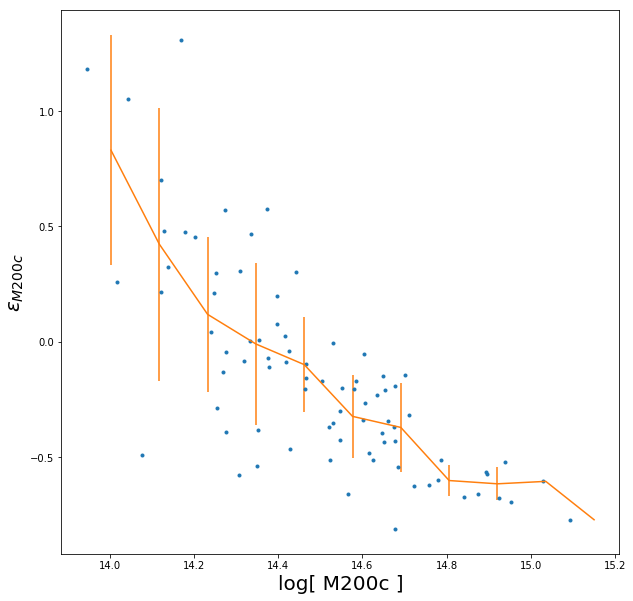

In [18]:
X = np.log10(datares['M200c'].astype('float64'))
Y = (datares['ep_M200c'].astype('float64'))
plt.plot(X,Y,'.')
plt.xlabel('log[ M200c ]', fontsize=20)
plt.ylabel(r'$\epsilon_{M200c}$', fontsize=20)

plothist(X,Y,10)

cluster index: 20
velocity standard deviation: 690.939
cluster M500 from SZ: 2.912e+14
cluster M200c: 4.13e+14


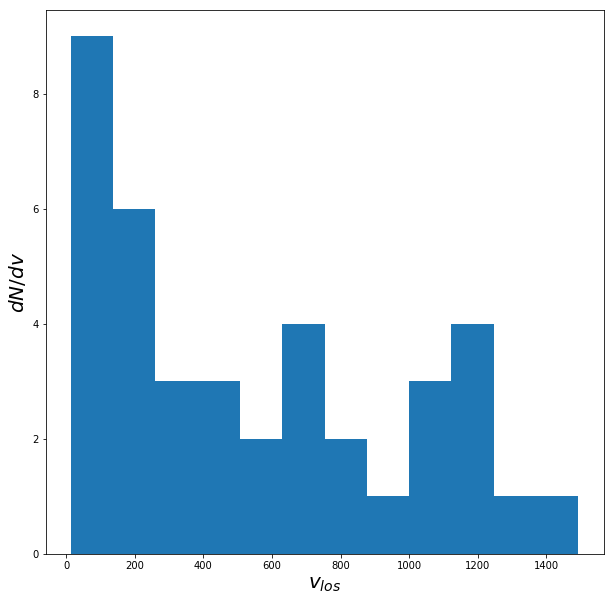

In [19]:
n = 20

Ngal = dat['Ngal'][n]
vlos = dat['vlos'][n][0:Ngal]

h = plt.hist(np.absolute(vlos), 12)
plt.xlabel(r'$v_{los}$', fontsize=20)
plt.ylabel(r'$dN/dv$', fontsize=20)

print('cluster index:', n)
print('velocity standard deviation:', np.std(dat['vlos'][n][0:Ngal])) 
print ('cluster M500 from SZ:', dat['MSZ'][n])
print ('cluster M200c:', dat['Mtot'][n])

# Using HeCS to train SDM

In [46]:
type(dat)

for n in range(len(dat)):
    Ngal = dat['Ngal'][n]
    
    velsigma = np.std(dat['vlos'][n][0:Ngal])
    m500 = dat['MSZ'][n]
    m200c = dat['Mtot'][n]
    
    datasum.loc[n] = pd.Series({'velsigma':velsigma ,
                                'M500_SZ' : m500 ,
                                'M200c' : m200c })

In [47]:
dat = np.load('./data/HeCS_pared_small.npy')

featuresList = []
massList = []

numHalos = len(dat)

#loop through all of the halos
for h in range(numHalos):
        numSubs = dat['Ngal'][h]
        
        #make a numpy array that will hold, in this case, 3 features for each of the numSubs subhalos.  Be aware that SDM requires at least 2 dimensions, so if you want to use line of sight velocity, you'll have to fill in a dummy value for the 2nd dimension.  I used an array of 1.0's
        subfeat = np.zeros((numSubs, 2), 'f')
        
        #loop through the subhalos/galaxies in this halo:
        for sh in range (0, numSubs):
            #and fill in each of the features
            subfeat[sh][0] = np.abs(dat['vlos'][h][sh])
            subfeat[sh][1] = 1.0

        #append the numpy array of features to the featuresList
        featuresList.append(subfeat)
        #and the mass to the massList
        massList.append(dat['Mtot'])

#turn this into a features object:
# features = sdm.Features(featuresList, mass=massList)

#model.crossvalidate is the workhorse.  It will do the 10-fold crossvalidation to predict answers for all of your data.  It outputs root mean squared error (rmse) and mass predictions:
# rmse, predictions = model.crossvalidate(trainData, trainData.mass)

In [48]:
tempres = np.load('./tempresults.npy', encoding='latin1').item()
tempres.keys()

dict_keys(['mass', 'feat', 'predictions', 'rmse'])

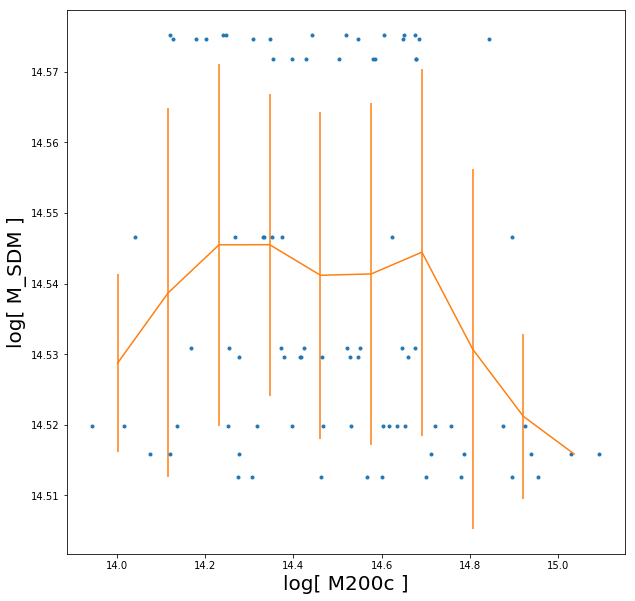

In [49]:
X = np.log10(tempres['mass']).astype('float64')
Y = np.log10(tempres['predictions']).astype('float64')
plt.plot(X,Y,'.')
plt.xlabel('log[ M200c ]', fontsize=20)
plt.ylabel('log[ M_SDM ]', fontsize=20)

plothist(X,Y,10)

In [40]:
X.astype

dtype('float32')

array([ 14.57518784,  14.52955867,  14.51587384,  14.51982797,
        14.57518784,  14.51255098,  14.57460993,  14.57170882,
        14.57460993,  14.57518784,  14.53083977,  14.53083977,
        14.54654266,  14.52955867,  14.54654266,  14.51982797,
        14.57460993,  14.57460993,  14.57460993,  14.53083977,
        14.51982797,  14.51982797,  14.53083977,  14.51982797,
        14.51255098,  14.51587384,  14.57170882,  14.51982797,
        14.52955867,  14.54654266,  14.51982797,  14.51982797,
        14.51255098,  14.51587384,  14.51587384,  14.57460993,
        14.57460993,  14.51587384,  14.51255098,  14.57518784,
        14.52955867,  14.57518784,  14.57170882,  14.51587384,
        14.51982797,  14.57170882,  14.54654266,  14.51255099,
        14.51587384,  14.51982797,  14.51982797,  14.57170882,
        14.57460993,  14.52955867,  14.51255098,  14.54654266,
        14.52955867,  14.51982797,  14.54654266,  14.52955867,
        14.51255098,  14.51982797,  14.51255098,  14.53

# Minghan's Data (coma.p)

In [41]:
comadat = np.load('./data/coma.p')[0]

cluster: COMA
('velocity standard deviation:', 568.73431)
('mass from power law:', '1.289e+14')


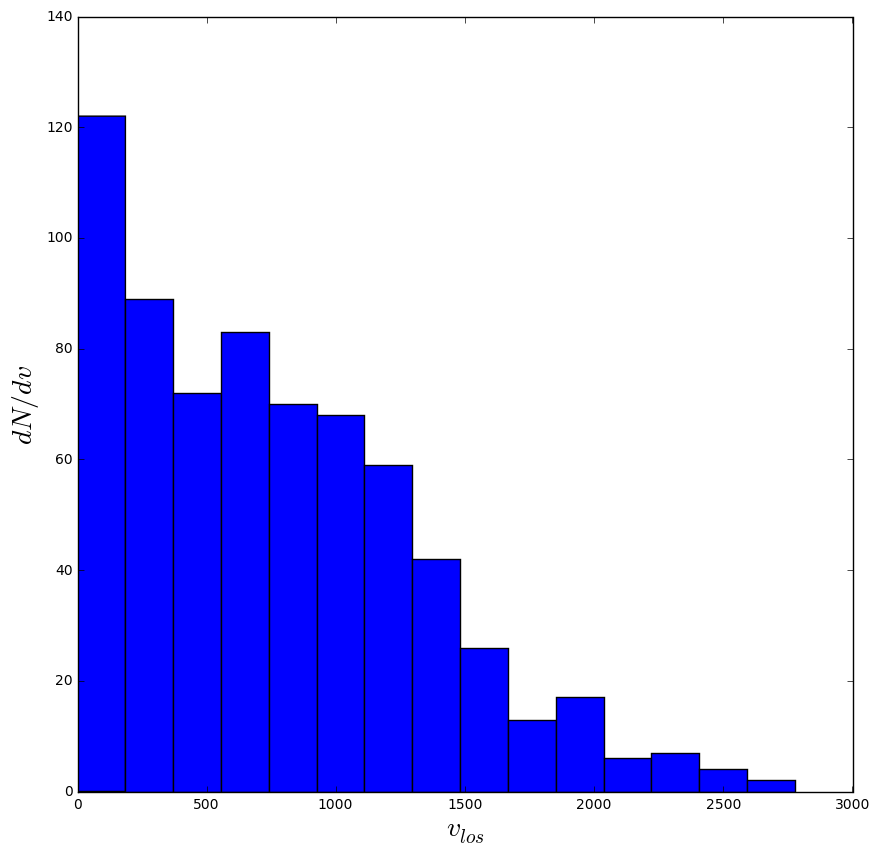

In [45]:
vlos = []
for i in comadat:
    vlos.append(i[0])
    
h = plt.hist(vlos, 15)
plt.xlabel(r'$v_{los}$', fontsize=20)
plt.ylabel(r'$dN/dv$', fontsize=20)

velsigma_coma = np.std(vlos)
M_pow_coma = (velsigma_coma/sig15)**(1/alpha) * 1.e15

print ('cluster: COMA')
print ('velocity standard deviation:', np.std(vlos))
print ('mass from power law:', "%.4g" % M_pow_coma)